In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split

In [2]:
# Custom Dataset
class RetinaDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
data_dir = '/kaggle/input/retina-image-for-binary-classification/dataset'

In [5]:
print(data_dir)

/kaggle/input/retina-image-for-binary-classification/dataset


In [4]:
# Data preparation
def prepare_data(data_dir):
    retina_dir = os.path.join(data_dir, 'train_images')  # Change this to 'train_images'
    non_retina_dir = os.path.join(data_dir, 'non-dr')    # Change this to 'non-dr'

    retina_images = [os.path.join(retina_dir, img) for img in os.listdir(retina_dir)]
    non_retina_images = [os.path.join(non_retina_dir, img) for img in os.listdir(non_retina_dir)]

    all_images = retina_images + non_retina_images
    labels = [1] * len(retina_images) + [0] * len(non_retina_images)

    return train_test_split(all_images, labels, test_size=0.2, random_state=42)

In [5]:
def get_model(num_classes=2):
    model = models.densenet121(pretrained=True)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, num_classes)
    return model

In [6]:
# Training function with progress bars and accuracy
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop with progress bar
        with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1}/{num_epochs}") as tepoch:
            for inputs, labels in tepoch:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                train_acc = correct / total  # Calculate accuracy

                # Update progress bar with the current loss and accuracy
                tepoch.set_postfix(loss=loss.item(), accuracy=100. * train_acc)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation loop with progress bar
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with tqdm(val_loader, unit="batch", desc="Validating") as vepoch:
            with torch.no_grad():
                for inputs, labels in vepoch:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    val_total += labels.size(0)
                    val_correct += predicted.eq(labels).sum().item()

                    val_acc = val_correct / val_total  # Calculate validation accuracy

                    # Update progress bar with the current validation loss and accuracy
                    vepoch.set_postfix(val_loss=loss.item(), val_accuracy=100. * val_acc)

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


In [8]:
# Main execution
def main():
    batch_size = 32
    num_epochs = 25
    learning_rate = 0.001

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Prepare data
    train_images, val_images, train_labels, val_labels = prepare_data(data_dir)

    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets and dataloaders
    train_dataset = RetinaDataset(train_images, train_labels, transform=transform)
    val_dataset = RetinaDataset(val_images, val_labels, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss function, and optimizer
    model = get_model()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, device=device)

    # Save the trained model
    torch.save(model.state_dict(), 'densenet121_retina_classifier.pth')

if __name__ == '__main__':
    main()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 159MB/s] 
Validating: 100%|██████████| 48/48 [02:02<00:00,  2.55s/batch, val_accuracy=99.7, val_loss=0.00198] 


Epoch 1/25:
Train Loss: 0.0260, Train Acc: 0.9906
Val Loss: 0.0077, Val Acc: 0.9974


Validating: 100%|██████████| 48/48 [01:36<00:00,  2.02s/batch, val_accuracy=99.9, val_loss=2.48e-5] 


Epoch 2/25:
Train Loss: 0.0217, Train Acc: 0.9937
Val Loss: 0.0035, Val Acc: 0.9993


Validating: 100%|██████████| 48/48 [01:35<00:00,  1.99s/batch, val_accuracy=99.8, val_loss=3.68e-6] 


Epoch 3/25:
Train Loss: 0.0015, Train Acc: 0.9997
Val Loss: 0.0046, Val Acc: 0.9980


Validating: 100%|██████████| 48/48 [01:35<00:00,  1.99s/batch, val_accuracy=99.9, val_loss=1.27e-5] 


Epoch 4/25:
Train Loss: 0.0004, Train Acc: 1.0000
Val Loss: 0.0009, Val Acc: 0.9993


Validating: 100%|██████████| 48/48 [01:36<00:00,  2.02s/batch, val_accuracy=99.9, val_loss=7.34e-8] 


Epoch 5/25:
Train Loss: 0.0008, Train Acc: 0.9995
Val Loss: 0.0055, Val Acc: 0.9987


Validating: 100%|██████████| 48/48 [01:35<00:00,  1.99s/batch, val_accuracy=99.9, val_loss=9.9e-7]  


Epoch 6/25:
Train Loss: 0.0004, Train Acc: 1.0000
Val Loss: 0.0027, Val Acc: 0.9993


Validating: 100%|██████████| 48/48 [01:35<00:00,  1.98s/batch, val_accuracy=100, val_loss=3.31e-6] 


Epoch 7/25:
Train Loss: 0.0001, Train Acc: 1.0000
Val Loss: 0.0004, Val Acc: 1.0000


Validating: 100%|██████████| 48/48 [01:35<00:00,  1.98s/batch, val_accuracy=72.3, val_loss=2.11] 


Epoch 8/25:
Train Loss: 0.0020, Train Acc: 0.9993
Val Loss: 1.8170, Val Acc: 0.7231


Validating: 100%|██████████| 48/48 [01:36<00:00,  2.00s/batch, val_accuracy=99.8, val_loss=0.0161] 


Epoch 9/25:
Train Loss: 0.0232, Train Acc: 0.9929
Val Loss: 0.0203, Val Acc: 0.9980


Validating: 100%|██████████| 48/48 [01:36<00:00,  2.02s/batch, val_accuracy=99.8, val_loss=3.08e-5] 


Epoch 10/25:
Train Loss: 0.0079, Train Acc: 0.9979
Val Loss: 0.0075, Val Acc: 0.9980


Validating: 100%|██████████| 48/48 [01:36<00:00,  2.00s/batch, val_accuracy=99.9, val_loss=2.45e-6] 


Epoch 11/25:
Train Loss: 0.0023, Train Acc: 0.9990
Val Loss: 0.0029, Val Acc: 0.9987


Validating: 100%|██████████| 48/48 [01:36<00:00,  2.01s/batch, val_accuracy=99.8, val_loss=3.48e-7] 


Epoch 12/25:
Train Loss: 0.0005, Train Acc: 0.9998
Val Loss: 0.0038, Val Acc: 0.9980


Validating: 100%|██████████| 48/48 [01:36<00:00,  2.01s/batch, val_accuracy=99.9, val_loss=5.14e-7] 


Epoch 13/25:
Train Loss: 0.0029, Train Acc: 0.9992
Val Loss: 0.0025, Val Acc: 0.9993


Validating: 100%|██████████| 48/48 [01:35<00:00,  1.99s/batch, val_accuracy=99.9, val_loss=3.03e-7] 


Epoch 14/25:
Train Loss: 0.0027, Train Acc: 0.9993
Val Loss: 0.0029, Val Acc: 0.9987


Validating: 100%|██████████| 48/48 [01:36<00:00,  2.02s/batch, val_accuracy=99.8, val_loss=6.24e-6] 


Epoch 15/25:
Train Loss: 0.0032, Train Acc: 0.9993
Val Loss: 0.0093, Val Acc: 0.9980


Validating: 100%|██████████| 48/48 [01:36<00:00,  2.01s/batch, val_accuracy=99.9, val_loss=1.12e-6] 


Epoch 16/25:
Train Loss: 0.0020, Train Acc: 0.9992
Val Loss: 0.0038, Val Acc: 0.9987


Validating: 100%|██████████| 48/48 [01:36<00:00,  2.00s/batch, val_accuracy=99.8, val_loss=6.05e-7] 


Epoch 17/25:
Train Loss: 0.0002, Train Acc: 1.0000
Val Loss: 0.0075, Val Acc: 0.9980


Validating: 100%|██████████| 48/48 [01:36<00:00,  2.01s/batch, val_accuracy=99.9, val_loss=1.83e-8] 


Epoch 18/25:
Train Loss: 0.0060, Train Acc: 0.9975
Val Loss: 0.0080, Val Acc: 0.9987


Validating: 100%|██████████| 48/48 [01:35<00:00,  1.98s/batch, val_accuracy=99.9, val_loss=3.74e-6] 


Epoch 19/25:
Train Loss: 0.0076, Train Acc: 0.9982
Val Loss: 0.0036, Val Acc: 0.9993


Validating: 100%|██████████| 48/48 [01:36<00:00,  2.01s/batch, val_accuracy=99.7, val_loss=1.82e-6] 


Epoch 20/25:
Train Loss: 0.0012, Train Acc: 0.9997
Val Loss: 0.0087, Val Acc: 0.9974


Validating: 100%|██████████| 48/48 [01:35<00:00,  1.98s/batch, val_accuracy=99.9, val_loss=1.33e-6] 


Epoch 21/25:
Train Loss: 0.0008, Train Acc: 0.9998
Val Loss: 0.0073, Val Acc: 0.9993


Validating: 100%|██████████| 48/48 [01:35<00:00,  1.99s/batch, val_accuracy=99.9, val_loss=8.25e-8] 


Epoch 22/25:
Train Loss: 0.0004, Train Acc: 1.0000
Val Loss: 0.0051, Val Acc: 0.9993


Validating: 100%|██████████| 48/48 [01:35<00:00,  1.98s/batch, val_accuracy=99.9, val_loss=9.17e-8] 


Epoch 23/25:
Train Loss: 0.0004, Train Acc: 0.9998
Val Loss: 0.0044, Val Acc: 0.9993


Validating: 100%|██████████| 48/48 [01:35<00:00,  1.99s/batch, val_accuracy=99.9, val_loss=1.93e-7] 


Epoch 24/25:
Train Loss: 0.0002, Train Acc: 1.0000
Val Loss: 0.0082, Val Acc: 0.9993


Validating: 100%|██████████| 48/48 [01:35<00:00,  1.99s/batch, val_accuracy=99.9, val_loss=2.84e-7] 

Epoch 25/25:
Train Loss: 0.0001, Train Acc: 1.0000
Val Loss: 0.0051, Val Acc: 0.9993


In [9]:
if torch.cuda.is_available():
    print(f'Using GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}')
else:
    print('Using CPU')

Using GPU: Tesla T4


# Manual model testing

/tmp/ipykernel_36/3325536497.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))  # Change m

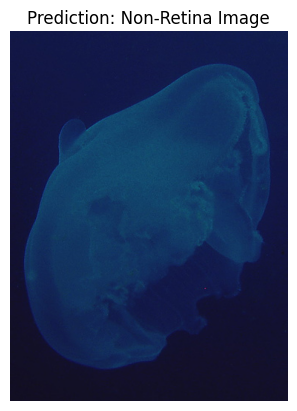

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms

# Load the saved model
def load_model(model_path, num_classes=2):
    model = models.densenet121(pretrained=False)  # Set pretrained=False since we are loading from a checkpoint
    num_ftrs = model.classifier.in_features
    model.classifier = torch.nn.Linear(num_ftrs, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))  # Change map_location to 'cpu' if no GPU available
    model.eval()  # Set the model to evaluation mode
    return model

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def predict_image(model, image_path, device='cuda'):
    model.to(device)
    
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    
    return predicted.item(), image

def display_image_and_prediction(model, image_path, device='cuda'):
    prediction, img = predict_image(model, image_path, device)

    plt.imshow(np.asarray(img))
    plt.axis('off')  
    label = "Retina Image" if prediction == 1 else "Non-Retina Image"
    plt.title(f"Prediction: {label}")
    
    plt.show()

model_path = 'densenet121_retina_classifier.pth'
model = load_model(model_path)

image_path = '/kaggle/input/retina-image-for-binary-classification/dataset/non-dr/ILSVRC2012_val_00000063.JPEG' 
display_image_and_prediction(model, image_path, device='cuda') 

# Fine Tuning the same Model

In [17]:
import torch
import torch.optim as optim
from torchvision import models
import torch.nn as nn

In [18]:
# Load the pre-trained model for fine-tuning
def get_fine_tuned_model(num_classes=2):
    model = models.densenet121(pretrained=True)
    
    for param in model.parameters():
        param.requires_grad = False

    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, num_classes)

    return model

In [22]:
# Training function for fine-tuning
def fine_tune_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, device='cuda'):
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")

        # Training loop
        for inputs, labels in train_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            train_loader_tqdm.set_postfix(loss=running_loss / len(train_loader), acc=correct / total)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation loop 
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")

        with torch.no_grad():
            for inputs, labels in val_loader_tqdm:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()


                val_loader_tqdm.set_postfix(loss=val_loss / len(val_loader), acc=val_correct / val_total)

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

In [23]:
# Main execution for fine-tuning with progress bars
def fine_tune_main():
    batch_size = 32
    num_epochs = 10
    learning_rate = 0.0001  # Lower learning rate for fine-tuning

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_images, val_images, train_labels, val_labels = prepare_data(data_dir)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = RetinaDataset(train_images, train_labels, transform=transform)
    val_dataset = RetinaDataset(val_images, val_labels, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = get_fine_tuned_model()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)  

    fine_tune_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, device=device)

    torch.save(model.state_dict(), 'densenet121_retina_finetuned.pth')

if __name__ == '__main__':
    fine_tune_main()

Epoch 1/10 [Validation]: 100%|██████████| 48/48 [01:36<00:00,  2.02s/it, acc=0.997, loss=0.135] 


Epoch 1/10:
Train Loss: 0.2998, Train Acc: 0.9483
Val Loss: 0.1347, Val Acc: 0.9974


Epoch 2/10 [Validation]: 100%|██████████| 48/48 [01:36<00:00,  2.01s/it, acc=0.999, loss=0.0589]


Epoch 2/10:
Train Loss: 0.0992, Train Acc: 0.9987
Val Loss: 0.0589, Val Acc: 0.9987


Epoch 3/10 [Validation]: 100%|██████████| 48/48 [01:35<00:00,  2.00s/it, acc=0.999, loss=0.0356]


Epoch 3/10:
Train Loss: 0.0589, Train Acc: 0.9985
Val Loss: 0.0356, Val Acc: 0.9987


Epoch 4/10 [Validation]: 100%|██████████| 48/48 [01:35<00:00,  2.00s/it, acc=0.999, loss=0.026] 


Epoch 4/10:
Train Loss: 0.0414, Train Acc: 0.9987
Val Loss: 0.0260, Val Acc: 0.9987


Epoch 5/10 [Validation]: 100%|██████████| 48/48 [01:35<00:00,  2.00s/it, acc=0.999, loss=0.0202] 


Epoch 5/10:
Train Loss: 0.0311, Train Acc: 0.9984
Val Loss: 0.0202, Val Acc: 0.9987


Epoch 6/10 [Validation]: 100%|██████████| 48/48 [01:35<00:00,  1.99s/it, acc=0.999, loss=0.0152] 


Epoch 6/10:
Train Loss: 0.0251, Train Acc: 0.9987
Val Loss: 0.0152, Val Acc: 0.9987


Epoch 7/10 [Validation]: 100%|██████████| 48/48 [01:36<00:00,  2.00s/it, acc=0.999, loss=0.0142] 


Epoch 7/10:
Train Loss: 0.0190, Train Acc: 0.9993
Val Loss: 0.0142, Val Acc: 0.9987


Epoch 8/10 [Validation]: 100%|██████████| 48/48 [01:35<00:00,  1.99s/it, acc=0.999, loss=0.011]  


Epoch 8/10:
Train Loss: 0.0182, Train Acc: 0.9987
Val Loss: 0.0110, Val Acc: 0.9987


Epoch 9/10 [Validation]: 100%|██████████| 48/48 [01:35<00:00,  2.00s/it, acc=0.999, loss=0.00976]


Epoch 9/10:
Train Loss: 0.0139, Train Acc: 0.9992
Val Loss: 0.0098, Val Acc: 0.9987


Epoch 10/10 [Validation]: 100%|██████████| 48/48 [01:35<00:00,  2.00s/it, acc=0.999, loss=0.00975]

Epoch 10/10:
Train Loss: 0.0134, Train Acc: 0.9992
Val Loss: 0.0098, Val Acc: 0.9987


/tmp/ipykernel_36/2401269277.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


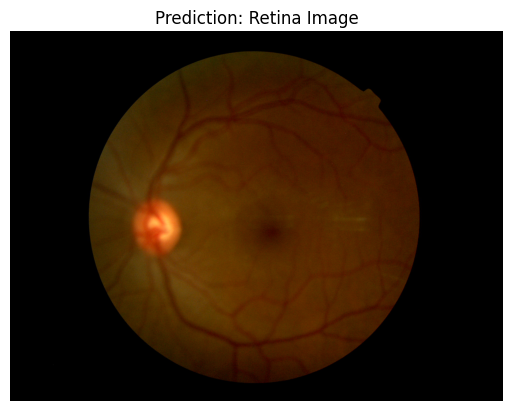

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms

def load_model(model_path, num_classes=2):
    model = models.densenet121(pretrained=False)
    num_ftrs = model.classifier.in_features
    model.classifier = torch.nn.Linear(num_ftrs, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))  
    model.eval()  
    return model

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def predict_image(model, image_path, device='cuda'):
    model.to(device)
    
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)
    
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    
    return predicted.item(), image

def display_image_and_prediction(model, image_path, device='cuda'):
    prediction, img = predict_image(model, image_path, device)

    plt.imshow(np.asarray(img))
    plt.axis('off')  
    label = "Retina Image" if prediction == 1 else "Non-Retina Image"
    plt.title(f"Prediction: {label}")
    
    plt.show()

model_path = 'densenet121_retina_classifier.pth'
model = load_model(model_path)

image_path = '/kaggle/input/retina-image-for-binary-classification/dataset/train_images/005b95c28852.png' 
display_image_and_prediction(model, image_path, device='cuda') 

In [27]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms

# Load the original model
def load_original_model(model_path, num_classes=2):
    model = models.densenet121(pretrained=False)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode
    return model

# Load the fine-tuned model
def load_fine_tuned_model(model_path, num_classes=2):
    model = models.densenet121(pretrained=False)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode
    return model

# Function to evaluate model performance
def evaluate_model(model, val_loader, criterion, device='cuda'):
    model.to(device)
    model.eval()

    total = 0
    correct = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = val_loss / len(val_loader)
    accuracy = correct / total

    return avg_loss, accuracy

# Main comparison function
def compare_models():
    batch_size = 32
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Data preparation
    train_images, val_images, train_labels, val_labels = prepare_data(data_dir)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_dataset = RetinaDataset(val_images, val_labels, transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Load both models
    original_model_path = 'densenet121_retina_classifier.pth'
    fine_tuned_model_path = 'densenet121_retina_finetuned.pth'

    original_model = load_original_model(original_model_path)
    fine_tuned_model = load_fine_tuned_model(fine_tuned_model_path)

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Evaluate both models
    print("Evaluating Original Model...")
    orig_loss, orig_acc = evaluate_model(original_model, val_loader, criterion, device)
    print(f'Original Model - Loss: {orig_loss:.4f}, Accuracy: {orig_acc:.4f}')

    print("Evaluating Fine-tuned Model...")
    fine_loss, fine_acc = evaluate_model(fine_tuned_model, val_loader, criterion, device)
    print(f'Fine-tuned Model - Loss: {fine_loss:.4f}, Accuracy: {fine_acc:.4f}')

    # Comparison
    print("\nComparison Summary:")
    print(f"Original Model - Loss: {orig_loss:.4f}, Accuracy: {orig_acc:.4f}")
    print(f"Fine-tuned Model - Loss: {fine_loss:.4f}, Accuracy: {fine_acc:.4f}")

if __name__ == '__main__':
    compare_models()

/tmp/ipykernel_36/1201912455.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
/tmp/ipykernel_36/1201912455.py:20: FutureWar

Evaluating Original Model...
Original Model - Loss: 0.0051, Accuracy: 0.9993
Evaluating Fine-tuned Model...
Fine-tuned Model - Loss: 0.0098, Accuracy: 0.9987

Comparison Summary:
Original Model - Loss: 0.0051, Accuracy: 0.9993
Fine-tuned Model - Loss: 0.0098, Accuracy: 0.9987
